In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
from sklearn import preprocessing
from sklearn.preprocessing import minmax_scale
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy.stats import skew

pd.set_option('max_columns', 500)

In [2]:
df_ng = pd.read_csv('/volumes/roussou/Microscopy/CellAsic/Atp6_NG_haploid/YPD/all_exp/multiExp_AllPos_acdc_output_all_ng_3d_haploids.csv')
df_mk = pd.read_csv('/volumes/roussou/Microscopy/CellAsic/Atp6_mKate_haploid/YPD/all_exp/multiExp_AllPos_acdc_output_all_mkate_3d_haploids.csv') 

In [3]:
df_ng_cap = pd.read_csv('/volumes/roussou/Microscopy/CellAsic/Atp6_NG_Chloramphenicol/Deltapdr5_1mg.ml_CAP/Positions/AllPos_acdc_output/AllPos_acdc_output__468.csv') 
df_mk_cap = pd.read_csv('/volumes/roussou/Microscopy/CellAsic/Atp6_mKate_Chloramphenicol/delta_pdr5_250123/Positions/AllPos_acdc_output/AllPos_acdc_output__146.csv')

In [60]:
df_ng_cap_fl = pd.read_csv('/volumes/roussou/Microscopy/CellAsic/Atp6_NG_Chloramphenicol/CAP_flushed_after_6hrs/Positions/AllPos_acdc_output/AllPos_acdc_output__1346.csv') 
df_mk_cap_fl = pd.read_csv('/volumes/roussou/Microscopy/CellAsic/Atp6_mKate_Chloramphenicol/CAP_flushed_after6hrs/Positions/AllPos_acdc_output/AllPos_acdc_output__1345.csv')

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (41,42) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [77]:
def normalise_to_first_two_hrs(df, intensity_column, max_frame):
    # Check if 'experiment_foldername' column exists in the DataFrame
    if 'experiment_foldername' in df.columns:
        # If it exists, include it in the columns to keep
        columns_to_keep = [
            "experiment_foldername",
            "Position_n",
            "frame_i",
            "Cell_ID",
            "cell_vol_fl",
            intensity_column,
        ]

        # Create 'exp_pos' using both 'experiment_foldername' and 'Position_n'
        df["exp_pos"] = (
            df["experiment_foldername"].astype(str)
            + "_"''
            + df["Position_n"].astype(str)

        )
    else:
        # If it doesn't exist, exclude it from the columns to keep
        columns_to_keep = [
            "Position_n",
            "frame_i",
            "Cell_ID",
            "cell_vol_fl",
            intensity_column,
        ]

        # Create 'exp_pos' using only 'Position_n'
        df["exp_pos"] = df["Position_n"].astype(str) 

    # Include 'exp_pos' in the columns to keep
    columns_to_keep.append("exp_pos")

    df_processed = df[columns_to_keep]

    df_processed["exp_pos_cell"] = (
        df_processed["exp_pos"].astype(str) + "_"
        + df_processed["Cell_ID"].astype(str)
    )

    df_processed["time"] = (15 * df_processed["frame_i"]).div(60)

    # Filter DataFrame based on the specified maximum frame
    df_processed = df_processed[df_processed.frame_i <= max_frame]

    df_first_8_frames = df_processed[df_processed.frame_i <= 8] 

    # Calculate normalization factors from the first 8 frames
    normalization_factors = (
        df_first_8_frames
        .groupby(["exp_pos"])
        .median()[
            [
                intensity_column,
            ]
        ]
    ).rename(columns={intensity_column: "norm_factor"})

    df_norm = df_processed.merge(
        normalization_factors, left_on="exp_pos", right_index=True, how="left"
    )

    normalized_column_name = f"{intensity_column}_norm"
    df_norm[normalized_column_name] = (
        df_norm[intensity_column] / df_norm.norm_factor
    )

    return df_norm

In [5]:
df_ng_norm = normalise_to_first_two_hrs(df=df_ng, intensity_column="_NG_3D_concentration_autoBkgr_from_vol_fl_meanProj", max_frame=32)
df_mk_norm = normalise_to_first_two_hrs(df=df_mk, intensity_column="_mKate_3D_concentration_autoBkgr_from_vol_fl_meanProj", max_frame=32)

<ipython-input-4-36485c9d6bab>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed["exp_pos_cell"] = (
<ipython-input-4-36485c9d6bab>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed["time"] = (15 * df_processed["frame_i"]).div(60)


In [6]:
df_ng_cap_norm = normalise_to_first_two_hrs(df=df_ng_cap, intensity_column="_NG_3D_concentration_autoBkgr_from_vol_fl_meanProj", max_frame=32)
df_mk_cap_norm = normalise_to_first_two_hrs(df=df_mk_cap, intensity_column="_mKate_3D_concentration_autoBkgr_from_vol_fl_meanProj", max_frame=32)

<ipython-input-4-36485c9d6bab>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed["exp_pos_cell"] = (
<ipython-input-4-36485c9d6bab>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed["time"] = (15 * df_processed["frame_i"]).div(60)


In [78]:
df_ng_cap_fl_norm = normalise_to_first_two_hrs(df=df_ng_cap_fl, intensity_column="_NG_3D_concentration_autoBkgr_from_vol_fl_meanProj", max_frame=50)
df_mk_cap_fl_norm = normalise_to_first_two_hrs(df=df_mk_cap_fl, intensity_column="_mKate_3D_concentration_autoBkgr_from_vol_fl_meanProj", max_frame=50)

<ipython-input-77-f5a8759b6aa8>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed["exp_pos_cell"] = (
<ipython-input-77-f5a8759b6aa8>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed["time"] = (15 * df_processed["frame_i"]).div(60)


In [79]:
# Chloramphenicol is introduced after 2hrs, 
# so we show the reduction of signal for the time cells are treated with CAP

df_mk_cap_norm_f = df_mk_cap_norm[df_mk_cap_norm['frame_i'] >= 8]
df_mk_norm_f = df_mk_norm[df_mk_norm['frame_i'] >= 8]

df_ng_cap_norm_f = df_ng_cap_norm[df_ng_cap_norm['frame_i'] >= 8]
df_ng_norm_f = df_ng_norm[df_ng_norm['frame_i'] >= 8]

df_ng_cap_fl_norm_f = df_ng_cap_fl_norm[df_ng_cap_fl_norm['frame_i'] >= 8]
df_mk_cap_fl_norm_f = df_mk_cap_fl_norm[df_mk_cap_fl_norm['frame_i'] >= 8]

In [15]:
### calculating degradation and maturation rate based on the +CAP expetiment

# Decay function:
def decay_function(t, A, k):
    return A * np.exp(-k * t)

In [16]:
grouped_mk_cap = df_mk_cap_norm_f.groupby('time')['_mKate_3D_concentration_autoBkgr_from_vol_fl_meanProj_norm'].agg(['median', 'std']).reset_index()
grouped_mk_cap.rename(columns={'median': 'norm_int_median', 'std': 'norm_int_std'}, inplace=True)

grouped_ng_cap = df_ng_cap_norm_f.groupby('time')['_NG_3D_concentration_autoBkgr_from_vol_fl_meanProj_norm'].agg(['median', 'std']).reset_index()
grouped_ng_cap.rename(columns={'median': 'norm_int_median', 'std': 'norm_int_std'}, inplace=True)

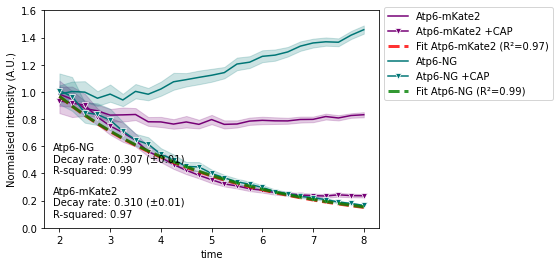

In [126]:
time = grouped_ng_cap['time']
ng_cap = grouped_ng_cap['norm_int_median']
mk_cap = grouped_mk_cap['norm_int_median']

# Curve fitting for 'mk_cap'
popt_mk_cap, pcov_mk_cap = curve_fit(decay_function, time, mk_cap)
decay_rate_mk_cap = popt_mk_cap[1]
half_life_mk_cap = np.log(2) / decay_rate_mk_cap

# Generate fitted curve using the decay function
fitted_curve_mk_cap = decay_function(time, *popt_mk_cap)

# Calculate R-squared for 'mk_cap'
r_squared_mk_cap = r2_score(mk_cap, fitted_curve_mk_cap)

standard_errors_mk = np.sqrt(np.diag(pcov_mk_cap))

# Extract the standard error of the decay rate
sem_decay_rate_mk = standard_errors_mk[1].round(3)

# Calculate the standard error for the half-life
sem_half_life_mk = round((np.log(2) / popt_mk_cap[1]**2) * sem_decay_rate_mk, 3)

# Calculate the standard error for the fitted curve
fitted_curve_sem_mk = round(np.sqrt(np.sum((mk_cap - fitted_curve_mk_cap)**2) / (len(mk_cap) - len(popt_mk_cap))), 3)

# PLOT Data
sns.lineplot(data=df_mk_norm_f, x="time", y="_mKate_3D_concentration_autoBkgr_from_vol_fl_meanProj_norm", color='#760076',label  = 'Atp6-mKate2')
sns.lineplot(data=df_mk_cap_norm_f, x="time", y="_mKate_3D_concentration_autoBkgr_from_vol_fl_meanProj_norm", marker = 'v',  color='#760076',label  = 'Atp6-mKate2 +CAP')

sns.lineplot(x=time, y=fitted_curve_mk_cap, color='red', alpha=0.8, linestyle='dashed', linewidth=3, label=f'Fit Atp6-mKate2 (R²={r_squared_mk_cap:.2f})')
#plt.text(0.9, 0.75, 'Fit ± {:.3f}'.format(fitted_curve_sem_mk), color='red', transform=plt.gca().transAxes)


mk_cap_text = 'Atp6-mKate2\nDecay rate: {:.3f} (±{:.2f})\nR-squared: {:.2f}'.format(
    decay_rate_mk_cap, sem_decay_rate_mk, r_squared_mk_cap)
plt.text(0.025, 0.05, mk_cap_text, transform=plt.gca().transAxes)


# Curve fitting for 'ng_cap' 
popt_ng_cap, pcov_ng_cap = curve_fit(decay_function, time, ng_cap)
decay_rate_ng_cap = popt_ng_cap[1]
half_life_ng_cap = np.log(2) / decay_rate_ng_cap

# Generate fitted curve using the decay function
fitted_curve_ng_cap = decay_function(time, *popt_ng_cap)

# Calculate R-squared for 'ng_cap' 
r_squared_ng_cap = r2_score(ng_cap, fitted_curve_ng_cap)

standard_errors_ng = np.sqrt(np.diag(pcov_ng_cap))

# Extract the standard error of the decay rate
sem_decay_rate_ng = standard_errors_ng[1].round(3)

# Calculate the standard error for the half-life
sem_half_life_ng = round((np.log(2) / popt_ng_cap[1]**2) * sem_decay_rate_ng, 3)

# Calculate the standard error for the fitted curve
fitted_curve_sem_ng = round(np.sqrt(np.sum((ng_cap - fitted_curve_ng_cap)**2) / (len(ng_cap) - len(popt_ng_cap))),3)

# PLOT Data
sns.lineplot(data=df_ng_norm_f, x="time", y="_NG_3D_concentration_autoBkgr_from_vol_fl_meanProj_norm",  color='#007676', label  = 'Atp6-NG')
sns.lineplot(data=df_ng_cap_norm_f, x="time", y="_NG_3D_concentration_autoBkgr_from_vol_fl_meanProj_norm", marker = 'v',  color='#007676', label  = 'Atp6-NG +CAP')

sns.lineplot(x=time, y=fitted_curve_ng_cap, color='green', alpha= 0.8, linestyle='dashed', linewidth=3, label=f'Fit Atp6-NG (R²={r_squared_ng_cap:.2f})')
#plt.text(0.9, 0.75, 'Fit ± {:.3f}'.format(fitted_curve_sem_ng), color='green', transform=plt.gca().transAxes)

ng_cap_text = 'Atp6-NG\nDecay rate: {:.3f} (±{:.2f})\nR-squared: {:.2f}'.format(
   decay_rate_ng_cap, sem_decay_rate_ng, r_squared_ng_cap)
plt.text(0.025,  0.25, ng_cap_text, transform=plt.gca().transAxes)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.8))
plt.ylabel('Normalised intensity (A.U.)')
plt.ylim(0,1.6)
plt.savefig('wt_cap_both_fluor_haploids.svg', transparent = True)

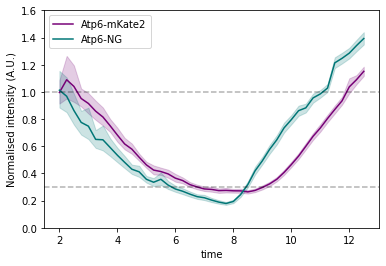

In [127]:
sns.lineplot(data=df_mk_cap_fl_norm_f, x="time", y="_mKate_3D_concentration_autoBkgr_from_vol_fl_meanProj_norm", color='#760076',label  = 'Atp6-mKate2')
sns.lineplot(data=df_ng_cap_fl_norm_f, x="time", y="_NG_3D_concentration_autoBkgr_from_vol_fl_meanProj_norm",  color='#007676', label  = 'Atp6-NG')
plt.axhline(y=0.3, color='k', linestyle='--', alpha = 0.3)
plt.axhline(y=1, color='k', linestyle='--', alpha = 0.3)
plt.ylabel('Normalised intensity (A.U.)')
plt.ylim(0,1.6)
plt.savefig('wt_cap_both_fluor_haploids_cap_flushed.svg', transparent = True)

In [89]:
# to calculate the synthesis rate we take the timepoint where both fluorophores have very reduced sigal (below 0.5)
# which leads to timepoint 7h and we calculate how fast they reach intensity 1 and intensity 1.4, by curve fitting 
# as done similarly for the degradation rate
df_mk_norm_cap_fl_mat = df_mk_cap_fl_norm_f[df_mk_cap_fl_norm_f.time >= 8]
df_mk_norm_cap_fl_mat

df_ng_norm_cap_fl_mat = df_ng_cap_fl_norm_f[df_ng_cap_fl_norm_f.time >= 8]
df_ng_norm_cap_fl_mat

,Position_n,frame_i,Cell_ID,cell_vol_fl,_NG_3D_concentration_autoBkgr_from_vol_fl_meanProj,exp_pos,exp_pos_cell,time,norm_factor,_NG_3D_concentration_autoBkgr_from_vol_fl_meanProj_norm
469,Position_1,32,1,98.203988,167.489077,Position_1,Position_1_1,8.0,1539.099812,0.108823
470,Position_1,32,2,67.275177,244.521663,Position_1,Position_1_2,8.0,1539.099812,0.158873
471,Position_1,32,8,56.887678,206.166497,Position_1,Position_1_8,8.0,1539.099812,0.133953
472,Position_1,32,10,54.998204,349.166379,Position_1,Position_1_10,8.0,1539.099812,0.226864
473,Position_1,32,16,77.970552,142.535498,Position_1,Position_1_16,8.0,1539.099812,0.092610
...,...,...,...,...,...,...,...,...,...,...
11352,Position_6,50,412,12.770853,2907.688899,Position_6,Position_6_412,12.5,980.295802,2.966134
11353,Position_6,50,413,6.910947,2034.102004,Position_6,Position_6_413,12.5,980.295802,2.074988
11354,Position_6,50,414,16.337656,1609.751831,Position_6,Position_6_414,12.5,980.295802,1.642108
11355,Position_6,50,415,3.456710,2737.257573,Position_6,Position_6_415,12.5,980.295802,2.792277


In [ ]:
# dropping Position_1 because it has NaN values...  (correct, probably ACDC saving error!)
df_mk_norm_cap_fl_mat = df_mk_norm_cap_fl_mat[df_mk_norm_cap_fl_mat['Position_n'] != 'Position_1']
df_mk_norm_cap_fl_mat

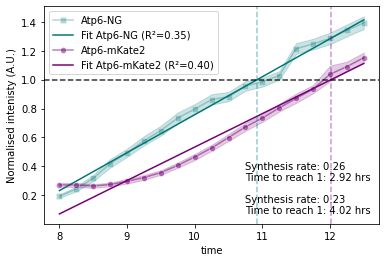

In [119]:
sns.lineplot(x='time', y="_NG_3D_concentration_autoBkgr_from_vol_fl_meanProj_norm", data=df_ng_norm_cap_fl_mat, color='#007676', marker="s", alpha=0.3, label='Atp6-NG')
x1 = df_ng_norm_cap_fl_mat['time']
y1 = df_ng_norm_cap_fl_mat['_NG_3D_concentration_autoBkgr_from_vol_fl_meanProj_norm']
coefficients_ng = np.polyfit(x1, y1, 1)
slope_ng = coefficients_ng[0]
poly_fit_ng = np.poly1d(coefficients_ng)
r_squared_ng = np.corrcoef(y1, poly_fit_ng(x1))[0, 1]**2  # Calculate R-squared
plt.plot(x1, poly_fit_ng(x1), label=f'Fit Atp6-NG (R²={r_squared_ng:.2f})', color='#007676')

sns.lineplot(x='time', y="_mKate_3D_concentration_autoBkgr_from_vol_fl_meanProj_norm", data=df_mk_norm_cap_fl_mat, color='#760076', marker="o", alpha=0.5, label='Atp6-mKate2')
x2 = df_mk_norm_cap_fl_mat['time']
y2 = df_mk_norm_cap_fl_mat['_mKate_3D_concentration_autoBkgr_from_vol_fl_meanProj_norm']
coefficients_mk = np.polyfit(x2, y2, 1)
slope_mk = coefficients_mk[0]
poly_fit_mk = np.poly1d(coefficients_mk)
r_squared_mk = np.corrcoef(y2, poly_fit_mk(x2))[0, 1]**2  # Calculate R-squared
plt.plot(x2, poly_fit_mk(x2), label=f'Fit Atp6-mKate2 (R²={r_squared_mk:.2f})', color='#760076')

# Find the time it takes for each dataset to reach norm_int=1
time_to_norm_int_1_ng = (1 - coefficients_ng[1]) / slope_ng
time_synthesis_ng = time_to_norm_int_1_ng - df_ng_norm_cap_fl_mat.time.iloc[0]
time_to_norm_int_1_mk = (1 - coefficients_mk[1]) / slope_mk
time_synthesis_mk = time_to_norm_int_1_mk - df_mk_norm_cap_fl_mat.time.iloc[0]

# Calculate the synthesis rate based on how quickly they reach norm_int=1
synth_rate_ng = 1 / time_to_norm_int_1_ng
synth_rate_mk = 1 / time_to_norm_int_1_mk

plt.axhline(y=1, color='k', linestyle='--', alpha = 0.8)

plt.axvline(x=time_to_norm_int_1_ng, color='#007676', linestyle='--', alpha = 0.4)
plt.axvline(x=time_to_norm_int_1_mk, color='#760076', linestyle='--', alpha = 0.4)

plt.text(0.6, 0.25, f'Synthesis rate: {slope_ng:.2f}', transform=plt.gca().transAxes)
plt.text(0.6, 0.2, f'Time to reach 1: {time_synthesis_ng:.2f} hrs', transform=plt.gca().transAxes)
# Plot R-squared value for Atp6-NG
#plt.text(0.6, 0.18, f'R²={r_squared_ng:.2f}', transform=plt.gca().transAxes, color='#007676')

plt.text(0.6, 0.1, f'Synthesis rate: {slope_mk:.2f}', transform=plt.gca().transAxes)
plt.text(0.6, 0.05, f'Time to reach 1: {time_synthesis_mk:.2f} hrs', transform=plt.gca().transAxes)
# Plot R-squared value for Atp6-mKate2
#plt.text(0.6, 0.05, f'R²={r_squared_mk:.2f}', transform=plt.gca().transAxes, color='#760076')

plt.ylabel('Normalised intenisty (A.U.)')
plt.legend()
plt.savefig('wt_cap_both_fluor_haploids_mat_rate.svg', transparent = True)